## Imports

In [2]:
import glob
import os
from os import walk
import tensorflow as tf
import cv2
import keras
from keras import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cross_validation import train_test_split
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam

%matplotlib inline

/home/sagar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/sagar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Set Variables and Paths


In [3]:
#path for training folder
train_dataset_dir = "/media/sagar/D/ctranz/newDataset/train" 
#path for testing folder
test_dataset_dir = "/media/sagar/D/ctranz/newDataset/validate" 
#target image size
img_size = 224 
#channels in image
img_channels = 3
#number of classes to be classified
num_classes = 4

#data_dict = {'data':None, 'labels':[], 'image_path':[]}
#Load the ResNet50 model

#resnet_model = resnet50.ResNet50(weights='imagenet')

### Data Augmentation at training and test time using data generators

In [4]:
#set batch size
batch_size = 60

#create data generator object for training data. This will do data augmentation at training time
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

#img = load_img('/media/sagar/D/ctranz/newDataset/test/SUV00.jpg')  # this is a PIL image
#x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
#x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
#print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
        
        
#create data generator object for test time augmentation        
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                                    train_dataset_dir,
                                    target_size=(img_size,img_size),
                                    batch_size=batch_size,
                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
                                    test_dataset_dir,
                                    target_size=(img_size,img_size),
                                    batch_size=batch_size,
                                    class_mode='categorical')

Found 277 images belonging to 4 classes.
Found 67 images belonging to 4 classes.


### Define the base model

In [5]:
#target shape of the image
input_shape = (224,224,3)

#choose pre-trained model. Here we have chosen InceptionV3 trained on Imagenet
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=input_shape)

#summarize the model
base_model.summary()


#SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:

#for i, layer in enumerate(base_model.layers):
#  print(i, layer.name)
# uncomment this code if you want to unfreeze few layers 

### Add fully-connected layer and softmax layer to the pre-trained network

In [7]:
nclass = 4

#x = base_model.output
#x = Flatten()(x)
#predictions = Dense(3, activation='softmax', name='predictions')(x)
#x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#predictions = Dense(5,activation='softmax')(x)
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
#predictions = Dense(4, activation='softmax')(x)

add_model = Sequential()
base_model.trainable = False
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())

#add_model.add(Flatten())
#add_model.add(Dropout(0.8))
#add_model.add(Dense(4000, activation='relu'))
#add_model.add(Dropout(0.5))

add_model.add(Dense(1024, activation='relu'))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass,activation='softmax'))
model = add_model

#model = Model(inputs=base_model.input,outputs=predictions)

#for i, layer in enumerate(model.layers):
#   print(i, layer.name)

### Compile the model by defining optimizer, loss function and accuracy metrics 

In [18]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

#Adam = optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()
#print(model.summary())

In [9]:
#history = model.fit_generator(train_generator, steps_per_epoch=None, epochs=10, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=True, shuffle=True, initial_epoch=0)

Epoch 1/10
 - 133s - loss: 2.1175 - acc: 0.3080 - val_loss: 1.3927 - val_acc: 0.3433
Epoch 2/10
 - 114s - loss: 1.3979 - acc: 0.3367 - val_loss: 1.5992 - val_acc: 0.4179
Epoch 3/10
 - 110s - loss: 1.3328 - acc: 0.4010 - val_loss: 1.1805 - val_acc: 0.5075
Epoch 4/10
 - 111s - loss: 1.1847 - acc: 0.5044 - val_loss: 1.1040 - val_acc: 0.5522
Epoch 5/10
 - 123s - loss: 1.1176 - acc: 0.5262 - val_loss: 0.9942 - val_acc: 0.5522
Epoch 6/10
 - 122s - loss: 1.0180 - acc: 0.5634 - val_loss: 0.9189 - val_acc: 0.5821
Epoch 7/10
 - 122s - loss: 1.0639 - acc: 0.5547 - val_loss: 0.8915 - val_acc: 0.5970
Epoch 8/10
 - 115s - loss: 1.0219 - acc: 0.5787 - val_loss: 0.9269 - val_acc: 0.6119
Epoch 9/10
 - 121s - loss: 0.9870 - acc: 0.6211 - val_loss: 1.2071 - val_acc: 0.5522
Epoch 10/10
 - 125s - loss: 0.9045 - acc: 0.6192 - val_loss: 0.9000 - val_acc: 0.6716


In [10]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(model.layers):
#   print(i, layer.name)
#model.fit_generator(train_generator, steps_per_epoch=None, epochs=50, verbose=2, callbacks=None, validation_data=test_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=30)

### Compile the model again if you chose to unfreeze some layers
#### Compile and train the network again if you unfreeze some layers of the base model

In [11]:
#for layer in model.layers[:150]:
#    layer.trainable = False
#for layer in model.layers[150:]:
#    layer.trainable = True
#from keras.optimizers import Adam

#model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
#history1 = model.fit_generator(train_generator, steps_per_epoch=None, epochs=20, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=0)


Epoch 1/20
 - 133s - loss: 0.9196 - acc: 0.5972 - val_loss: 1.0424 - val_acc: 0.5075
Epoch 2/20
 - 120s - loss: 0.8717 - acc: 0.6310 - val_loss: 0.9078 - val_acc: 0.5970
Epoch 3/20
 - 115s - loss: 0.8869 - acc: 0.6008 - val_loss: 0.8940 - val_acc: 0.5821
Epoch 4/20
 - 115s - loss: 0.9297 - acc: 0.5550 - val_loss: 0.8899 - val_acc: 0.6269
Epoch 5/20
 - 114s - loss: 0.9262 - acc: 0.6023 - val_loss: 1.0122 - val_acc: 0.5224
Epoch 6/20
 - 114s - loss: 0.9099 - acc: 0.6261 - val_loss: 0.8912 - val_acc: 0.6269
Epoch 7/20
 - 114s - loss: 0.9084 - acc: 0.6090 - val_loss: 0.9622 - val_acc: 0.5970
Epoch 8/20
 - 111s - loss: 0.9211 - acc: 0.5668 - val_loss: 0.8253 - val_acc: 0.6119
Epoch 9/20
 - 203s - loss: 0.8977 - acc: 0.5989 - val_loss: 0.8157 - val_acc: 0.6418
Epoch 10/20
 - 112s - loss: 0.9047 - acc: 0.5602 - val_loss: 0.9608 - val_acc: 0.5373
Epoch 11/20
 - 110s - loss: 0.8982 - acc: 0.6042 - val_loss: 1.1281 - val_acc: 0.5224
Epoch 12/20
 - 110s - loss: 0.8607 - acc: 0.6093 - val_loss: 0.

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=None, epochs=30, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=20)

Epoch 21/30
 - 131s - loss: 0.8778 - acc: 0.5940 - val_loss: 0.9857 - val_acc: 0.5970
Epoch 22/30
 - 126s - loss: 0.8605 - acc: 0.6125 - val_loss: 0.9584 - val_acc: 0.5970
Epoch 23/30
 - 130s - loss: 0.9040 - acc: 0.5938 - val_loss: 0.9143 - val_acc: 0.5522
Epoch 24/30
 - 132s - loss: 0.9077 - acc: 0.6293 - val_loss: 1.0287 - val_acc: 0.5373
Epoch 25/30
 - 129s - loss: 0.9234 - acc: 0.5838 - val_loss: 0.9093 - val_acc: 0.5373
Epoch 26/30
 - 122s - loss: 0.8689 - acc: 0.6464 - val_loss: 0.8957 - val_acc: 0.6119
Epoch 27/30
 - 124s - loss: 0.8941 - acc: 0.5820 - val_loss: 0.9824 - val_acc: 0.5373
Epoch 28/30
 - 122s - loss: 0.8906 - acc: 0.6462 - val_loss: 0.9718 - val_acc: 0.5522
Epoch 29/30
 - 118s - loss: 0.8950 - acc: 0.5955 - val_loss: 0.8251 - val_acc: 0.6269
Epoch 30/30
 - 114s - loss: 0.8809 - acc: 0.6191 - val_loss: 0.9499 - val_acc: 0.4925


### Plot training or validation loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
{'SUV': 0, 'car': 1, 'pickup': 2, 'truck': 3}


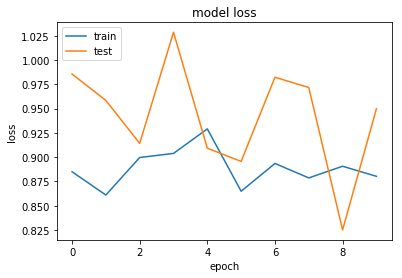

In [17]:
#
print(history.history.keys())
label_map = (train_generator.class_indices)
print(label_map)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

### Test your model on test image

class: [0]
The predicted vehicle is :  SUV
Predicted probabilities of all classes: [[0.5267577  0.14536898 0.3211729  0.00670039]]


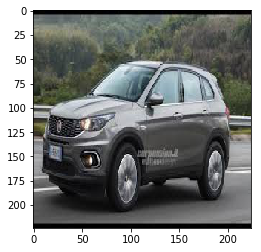

In [32]:
# path to test image
img_path = "/media/sagar/D/ctranz/newDataset/test/suv5.jpeg"

#pre-processing
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
plt.imshow(img)
#print(x.shape)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
#print('Input image shape:', x.shape)

#predict the class of test image
preds = model.predict(x)
y_classes = preds.argmax(axis=-1)
print('class:', y_classes)
for key , value in label_map.items():
    if value == y_classes:
        print("The predicted vehicle is : ",key)
print('Predicted probabilities of all classes:', preds)

### Save the model

In [15]:
#save the model
model.save('my_model.h5')

### Code to load the saved model

In [16]:
from keras.models import load_model
model = load_model('my_model.h5')

/home/sagar/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
